# Lingum-vitae

**Lingum-vitae**, based on **Teak**.. wayyyy more batches.. again

> 1000 batches of 9 entries each.
> only 200 epochs

#### Imports

In [1]:
import tensorflow as tf
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import time
import glob
import sys
import io

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

/Users/andrew/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Log ID

In [2]:
# log_random_serial_number = '{}'.format(np.random.randint(100000,999999))
# print(log_random_serial_number)
176021

176021

In [3]:
def log_dir(log_random_serial_number):
    master_log_path = '../../../logs/'
    log_num = len(glob.glob(master_log_path + log_random_serial_number + '*'))
    
    direc = master_log_path + log_random_serial_number
    if log_num > 0:
        # assumes less than 26 runs per graph
        direc += chr(ord('@') + log_num)
    return direc
log_direc = log_dir('176021')
print(log_direc)

../../../logs/176021


##### Flags

In [4]:
flags = tf.app.flags

# flag 'f' prevents an error due to using flags in jupyter notebook
#https://github.com/tensorflow/tensorflow/issues/17702#issuecomment-387335646
flags.DEFINE_string('f', '', 'kernel')

In [5]:
# Data parameters
flags.DEFINE_float("testing_data_percentage", 0.10,"Percentage of the data to use for testing. (default: 0.10)")
flags.DEFINE_string('data_path', '../../../data/wrapped_10000_moderate_gaussian_noise_A.bz2', "Data source for training and testing")

In [6]:
# training parameters
flags.DEFINE_integer('num_epochs', 200, "Number of training epochs (default: 200)")
flags.DEFINE_float('keep_prob', 0.50, "Dropout probability (default: 0.50)")
flags.DEFINE_float('learning_rate', 0.0001, "Learning rate (default: 0.001)")

In [7]:
FLAGS = tf.flags.FLAGS
# FLAGS(sys.argv)
# print("\nParameters:")
# for attr, value in sorted(FLAGS.__flags.items()):
#     print("{}={}".format(attr.upper(), value))
# print("")

#### Load, scale, split data

In [8]:
def load_data(data_path, output_col = 'tau'):
    """Loads data from csv. Returns inputs and outputs as DataFrames"""
    df = pd.read_csv(data_path)
    
    inputs = df.drop(output_col, axis = 1)
    outputs = df[[output_col]]
    
    return [inputs, outputs]

In [9]:
data = load_data(FLAGS.data_path)

In [10]:
def scale_data(data):
    """Returns scaled inputs & outputs, and their scalers."""
    input_scaler  = MinMaxScaler(feature_range = (0,1))
    output_scaler = MinMaxScaler(feature_range = (0,1))
    
    scaled_input  =  input_scaler.fit_transform(data[0])
    scaled_output = output_scaler.fit_transform(data[1])
    
    return [scaled_input, scaled_output, input_scaler, output_scaler]

In [11]:
scaled_input, scaled_output, input_scaler, output_scaler = scale_data(data)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(scaled_input, scaled_output,
                                                    test_size = FLAGS.testing_data_percentage,
                                                    random_state = np.random.seed(int(time.time())))

In [13]:
X_train.shape

(9000, 1024)

In [14]:
number_of_inputs  = scaled_input.shape[1]
number_of_outputs = scaled_output.shape[1]

In [15]:
layer_1_nodes = 256
layer_2_nodes = 128
layer_3_nodes = 64

In [16]:
tf.reset_default_graph()

In [17]:
with tf.variable_scope('input_X'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))
    
with tf.variable_scope('input_y'):
    y  = tf.placeholder(tf.float32, shape = (None, 1))
    
with tf.variable_scope('keep'):
    keep_prob = tf.placeholder(tf.float32)
    
with tf.variable_scope('layer_1'):

    biases = tf.get_variable(name = "biases1",
                             shape = [layer_1_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights1",
                              shape  = [number_of_inputs, layer_1_nodes], 
                              initializer = tf.contrib.layers.xavier_initializer())


    layer_1_output = tf.nn.leaky_relu(tf.matmul(X, weights) + biases)

with tf.variable_scope('dropout_12'):
    drop_out_12 = tf.nn.dropout(layer_1_output, keep_prob)     
      
with tf.variable_scope('layer_2'):

    biases = tf.get_variable(name = "biases2",
                             shape = [layer_2_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_1_nodes, layer_2_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_2_output = tf.nn.relu(tf.matmul(drop_out_12, weights) + biases)
    
with tf.variable_scope('layer_3'):

    biases = tf.get_variable(name = "biases2",
                             shape = [layer_3_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_2_nodes, layer_3_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)
    
with tf.variable_scope('output'):

    biases = tf.get_variable(name = "biases_out",
                             shape = [number_of_outputs],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights_out",
                              shape  = [layer_3_nodes, number_of_outputs],
                         initializer = tf.contrib.layers.xavier_initializer())


    prediction = tf.nn.relu(tf.matmul(layer_3_output, weights) + biases)
    
with tf.variable_scope('cost'):

    cost = tf.reduce_mean(tf.squared_difference(prediction, y))

with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(FLAGS.learning_rate, epsilon=1e-08).minimize(cost)

with tf.variable_scope('logging'):
    tf.summary.histogram('cost', cost)
    tf.summary.histogram('predictions', prediction)
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()

In [18]:
saver = tf.train.Saver()

 epoch:    4 testing_cost: 0.0908511654

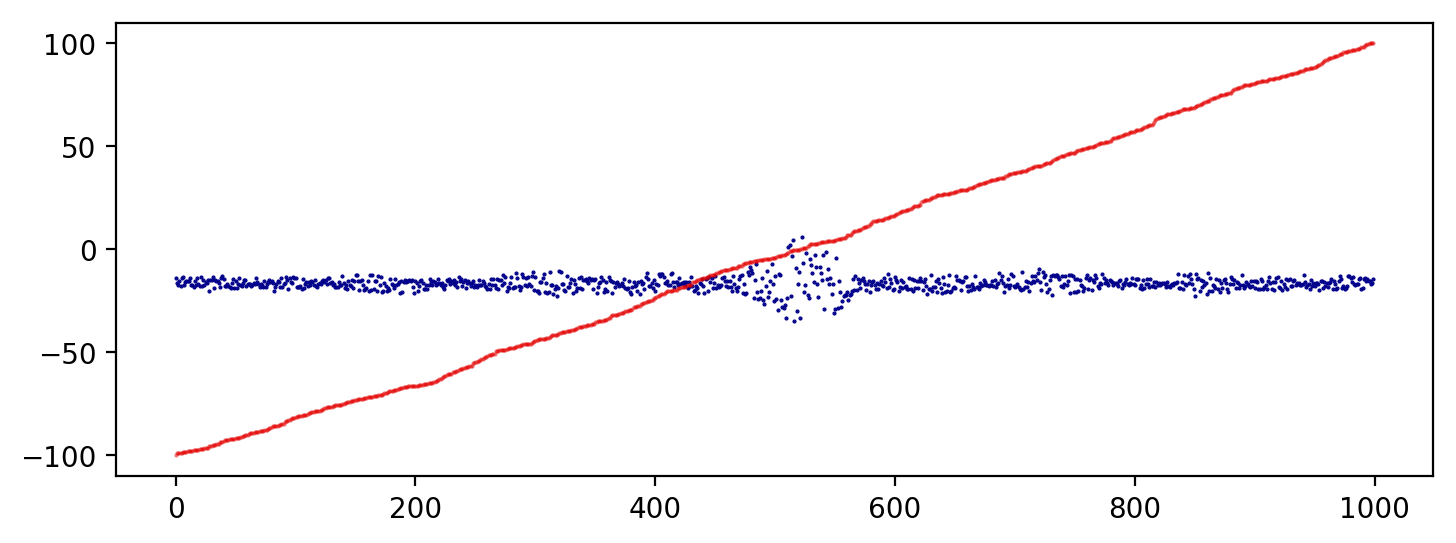

 epoch:    9 testing_cost: 0.0902306959

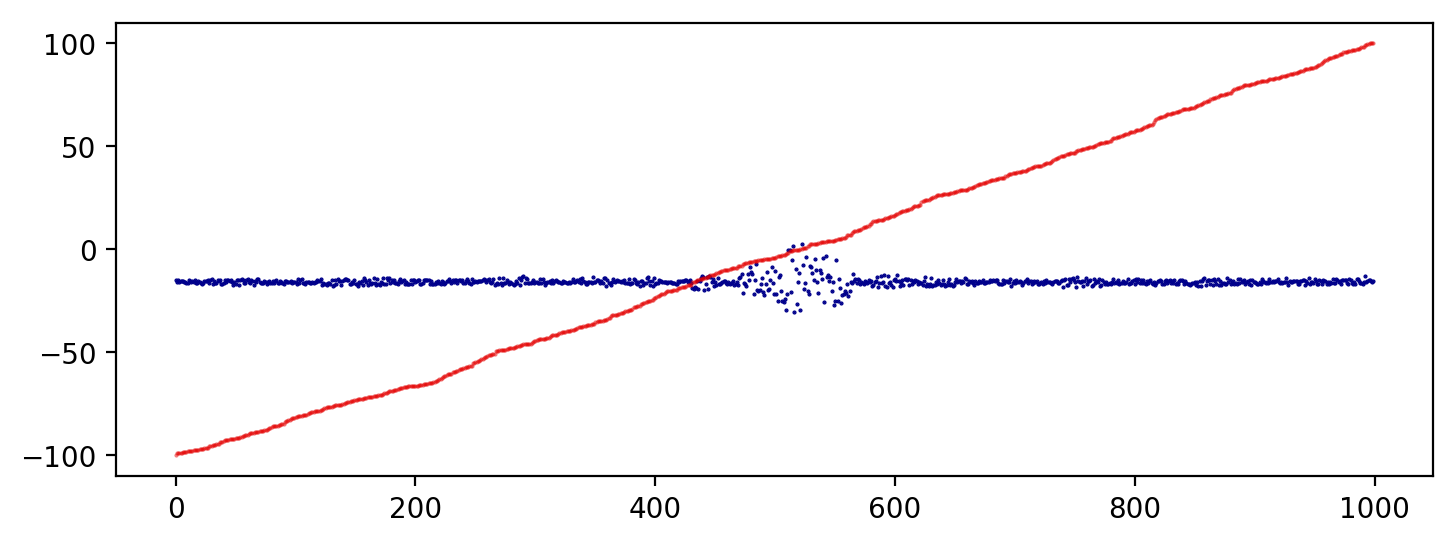

 epoch:   14 testing_cost: 0.0893169716

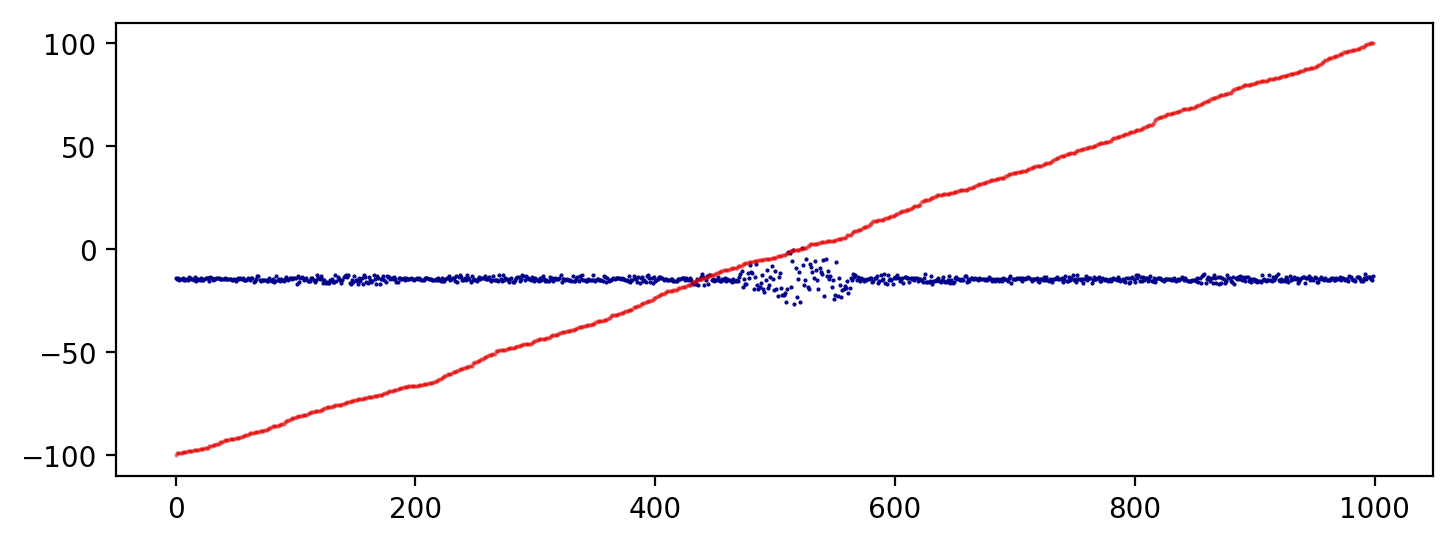

 epoch:   19 testing_cost: 0.0861645937

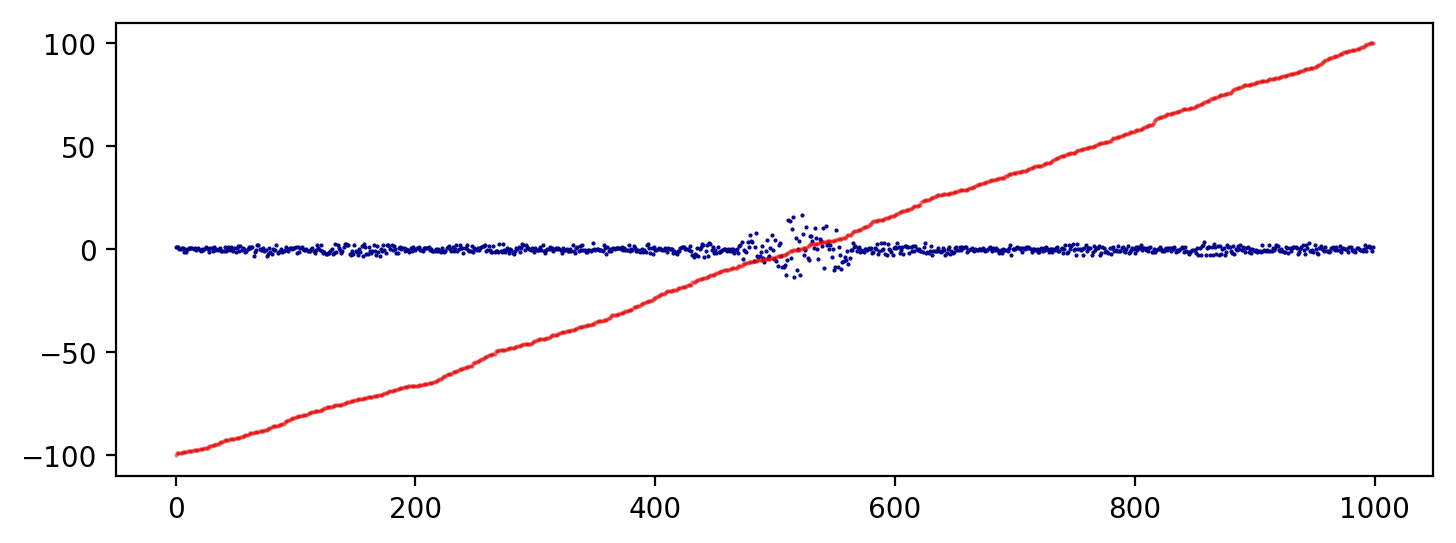

 epoch:   24 testing_cost: 0.0871422365

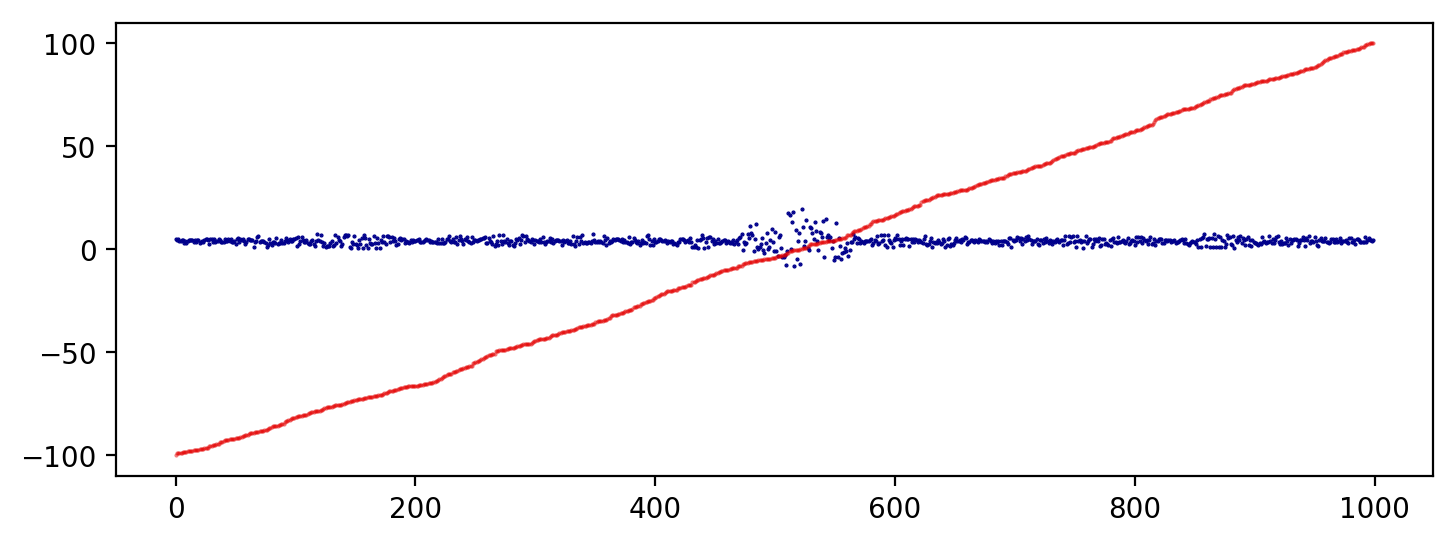

 epoch:   29 testing_cost: 0.0859780908

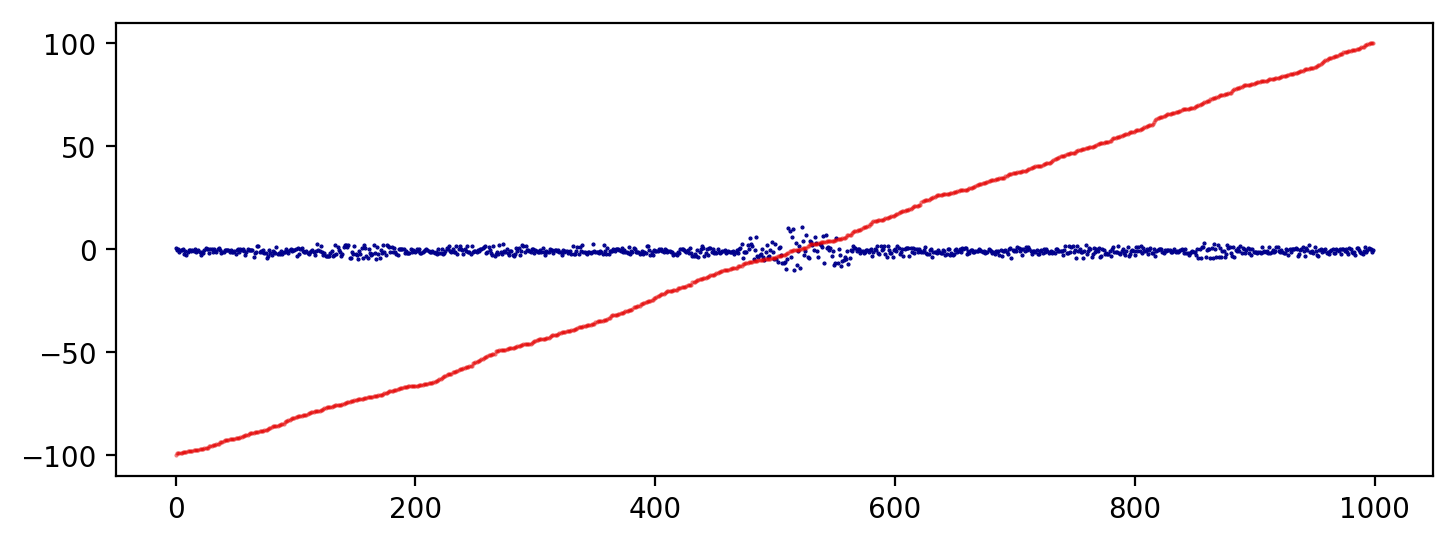

 epoch:   34 testing_cost: 0.0858309790

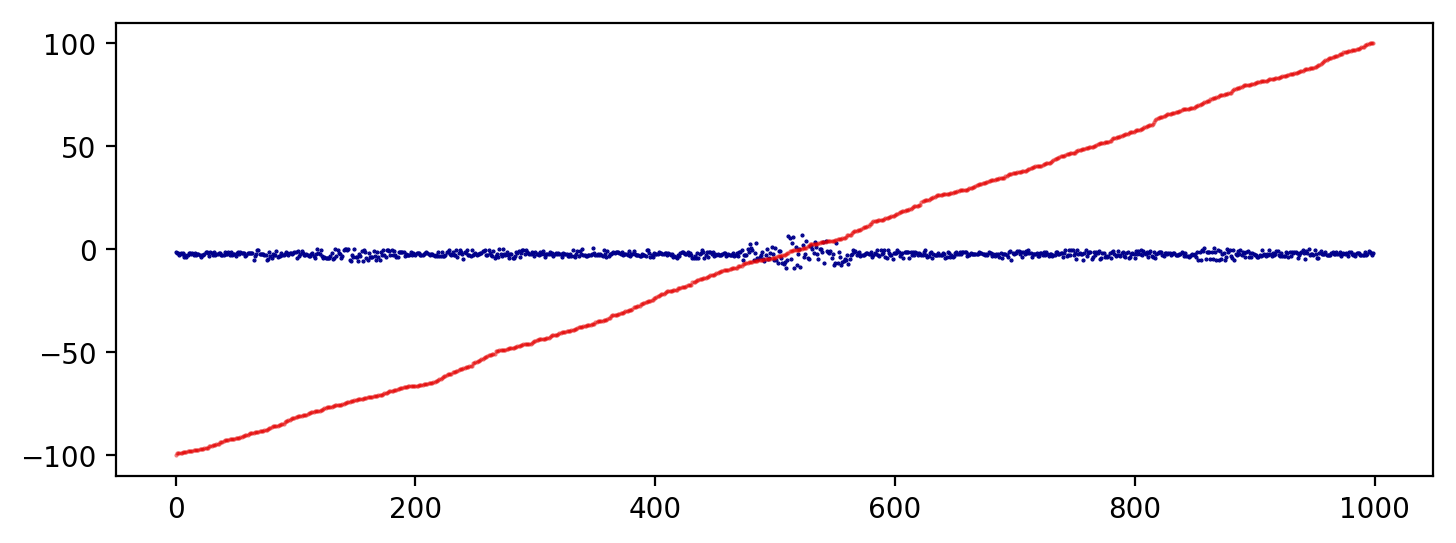

 epoch:   39 testing_cost: 0.0867327005

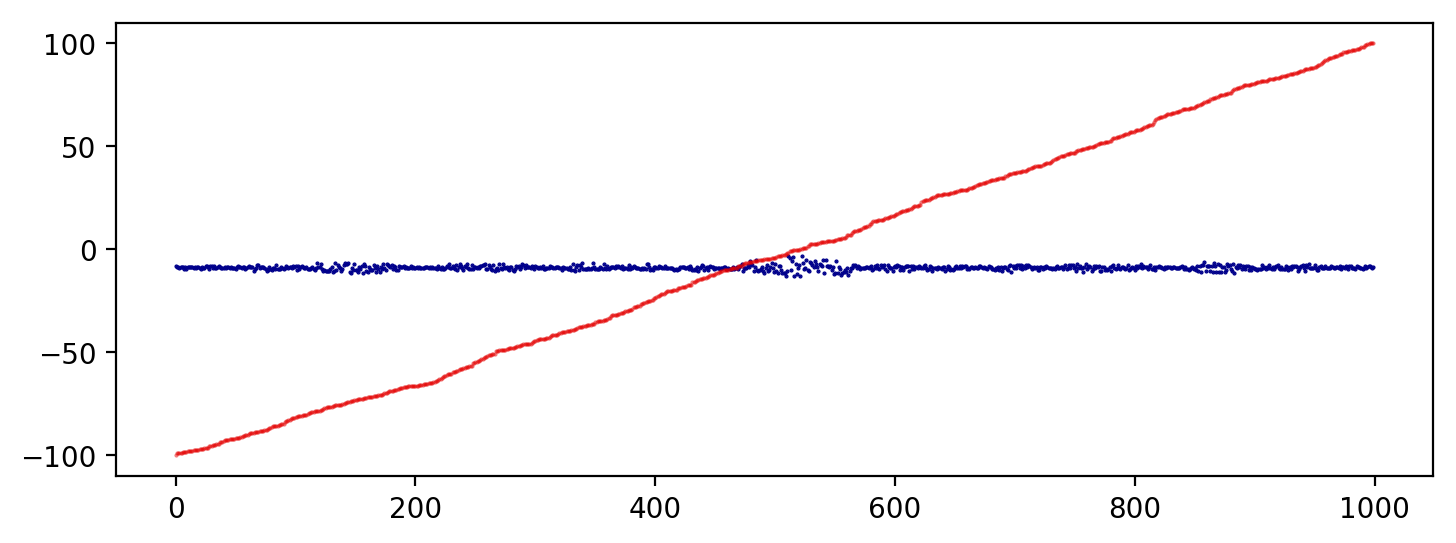

 epoch:   44 testing_cost: 0.0861972496

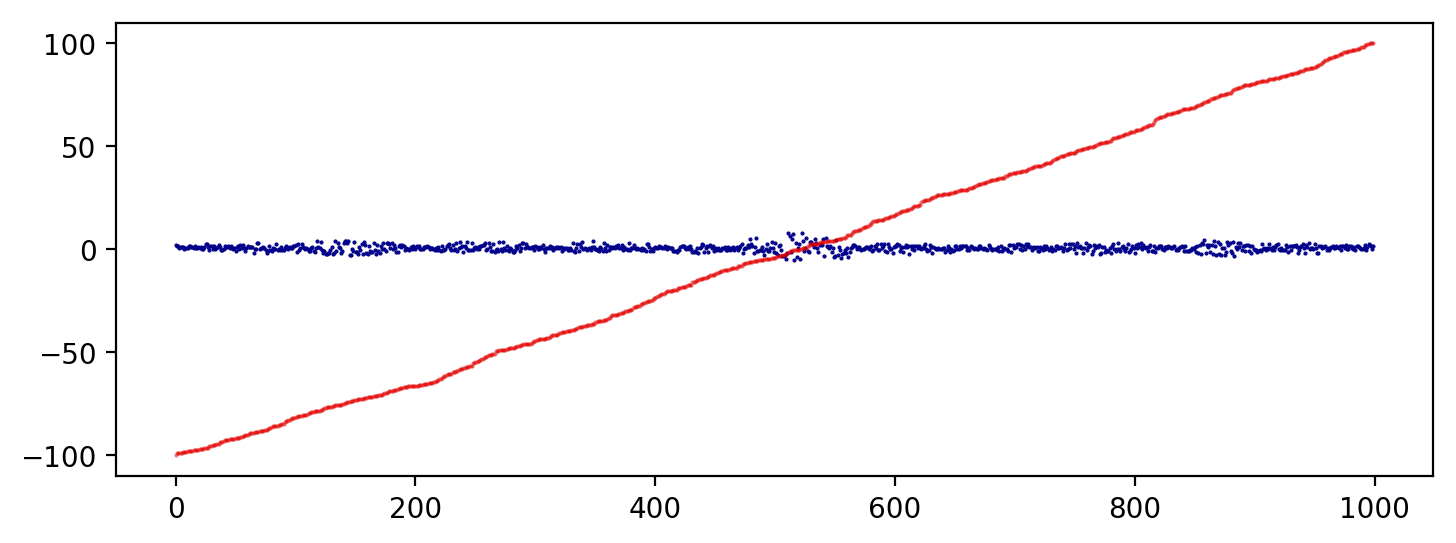

 epoch:   49 testing_cost: 0.0894866809

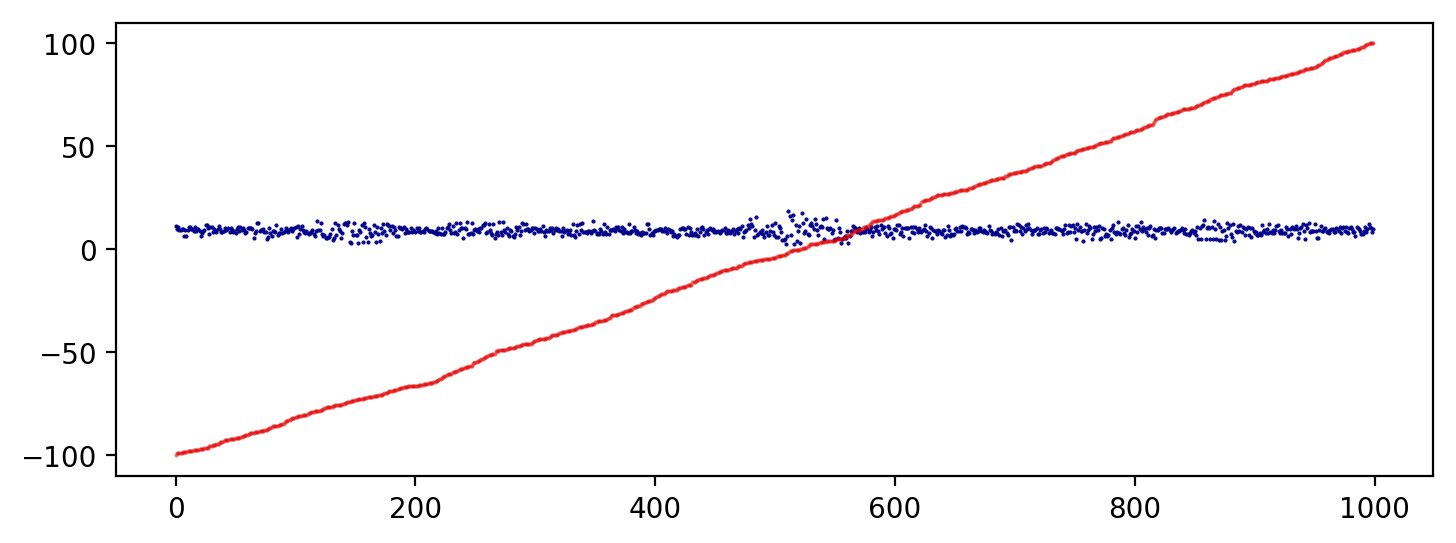

 epoch:   54 testing_cost: 0.0864120051

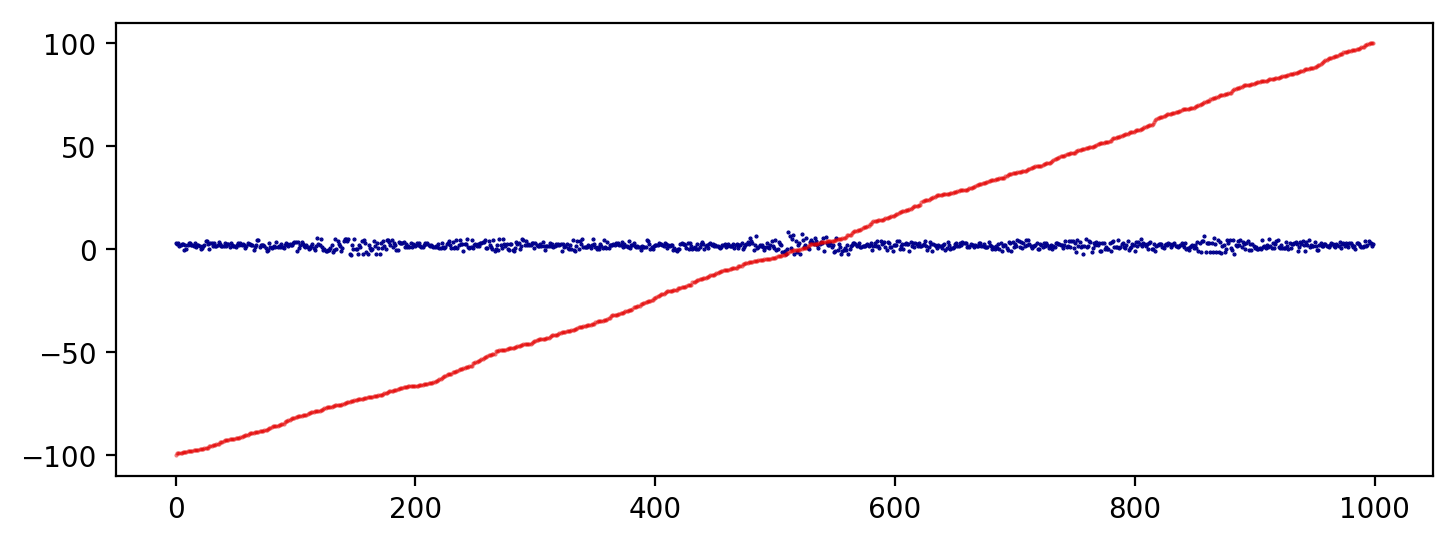

 epoch:   59 testing_cost: 0.0878310502

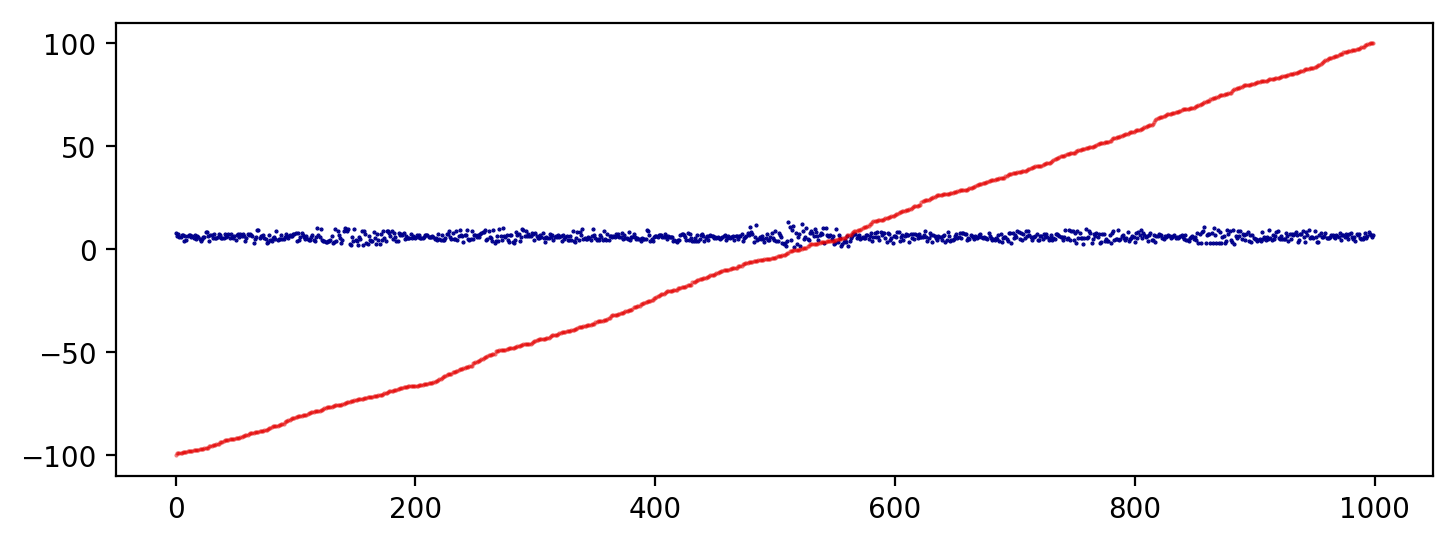

 epoch:   64 testing_cost: 0.0872856081

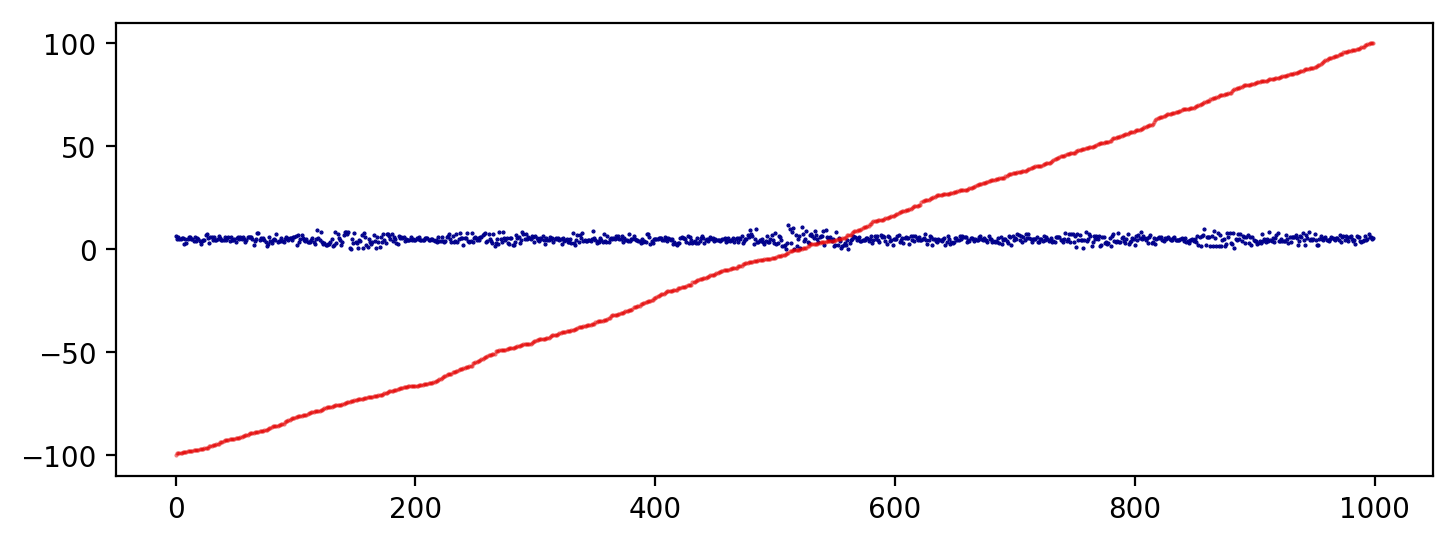

 epoch:   69 testing_cost: 0.0857543349

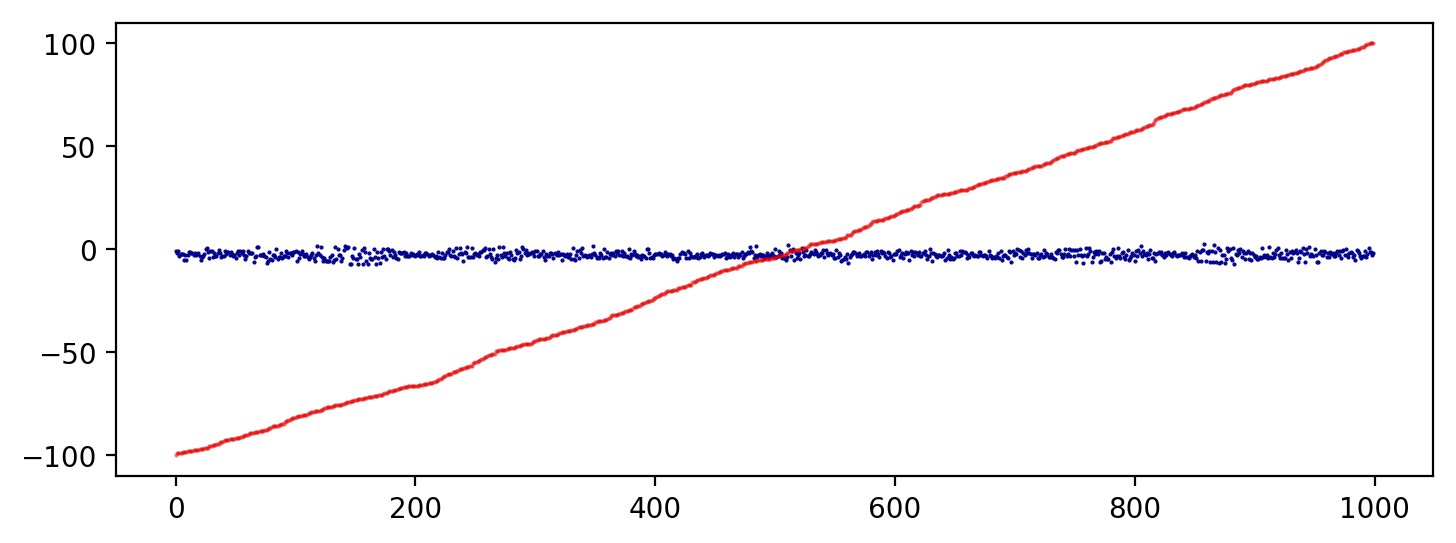

 epoch:   74 testing_cost: 0.0860446468

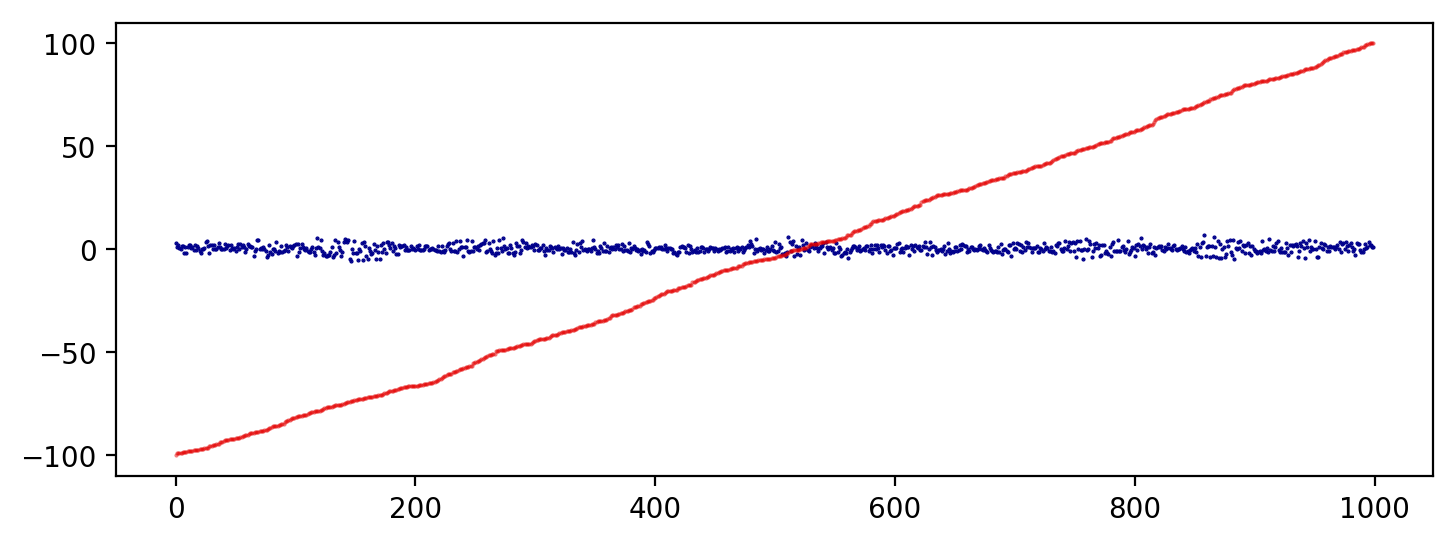

 epoch:   79 testing_cost: 0.0856775269

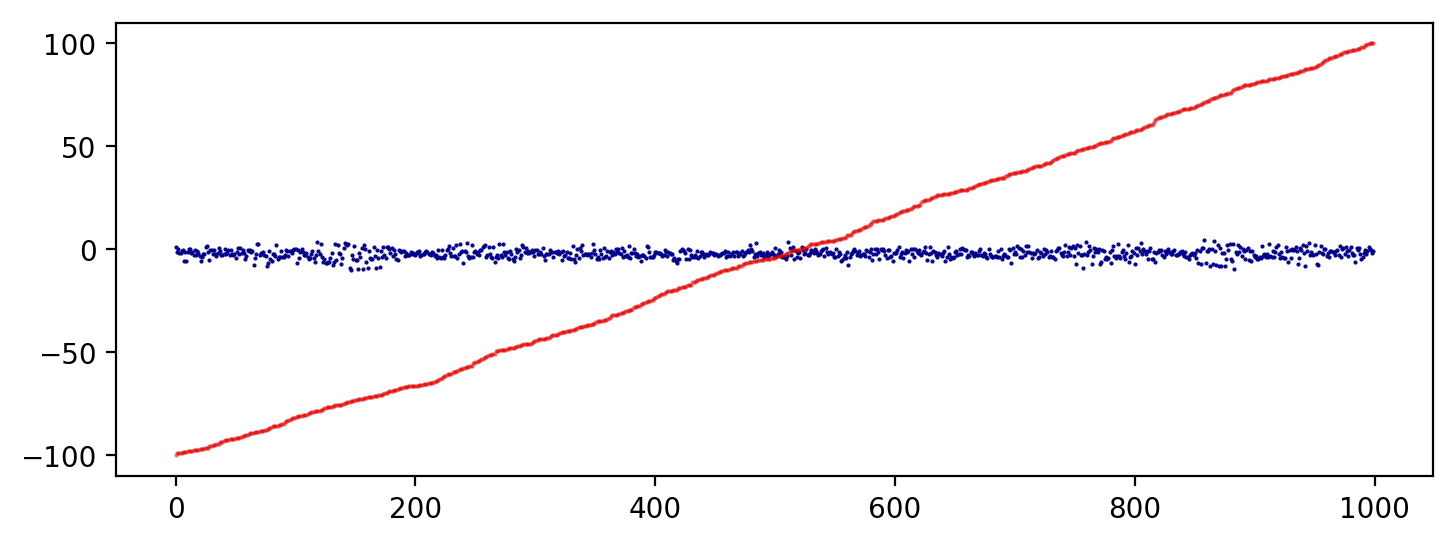

 epoch:   84 testing_cost: 0.0867600590

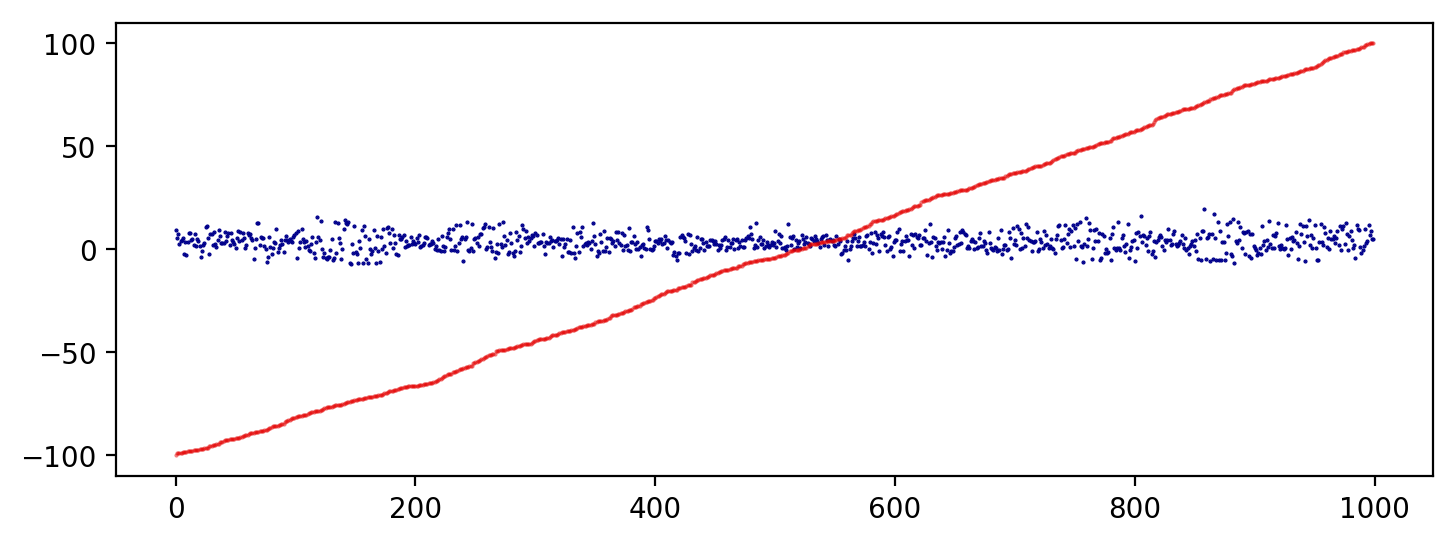

 epoch:   89 testing_cost: 0.0851276368

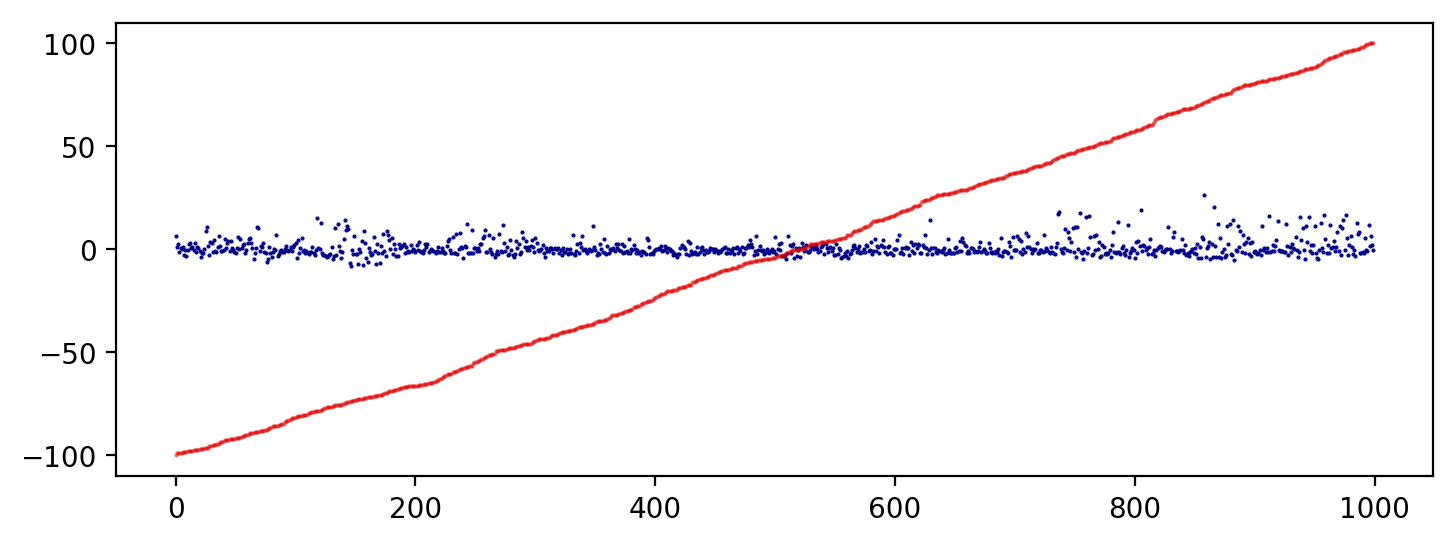

 epoch:   94 testing_cost: 0.0842259824

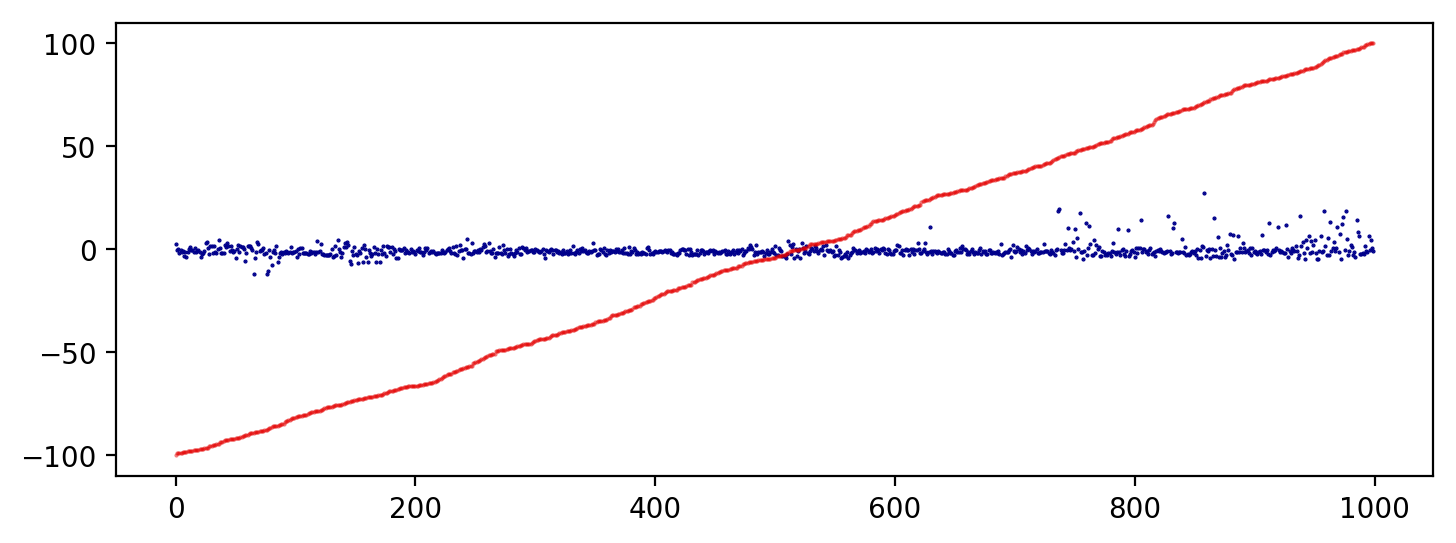

 epoch:   99 testing_cost: 0.0832892656

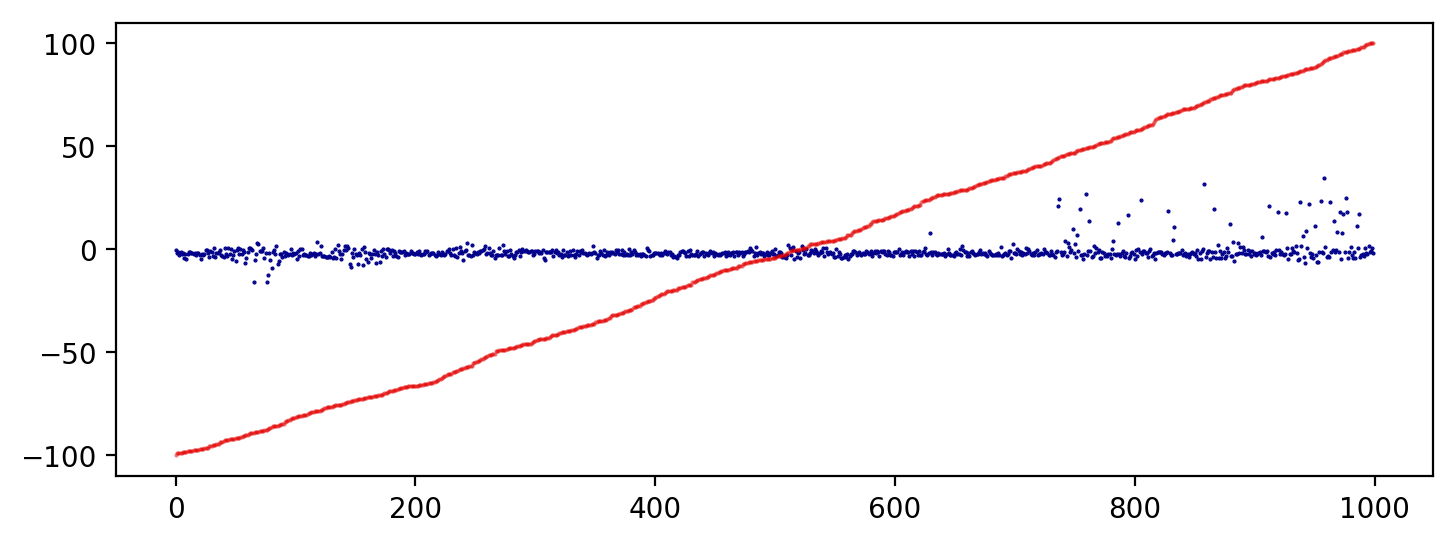

 epoch:  104 testing_cost: 0.0841304734

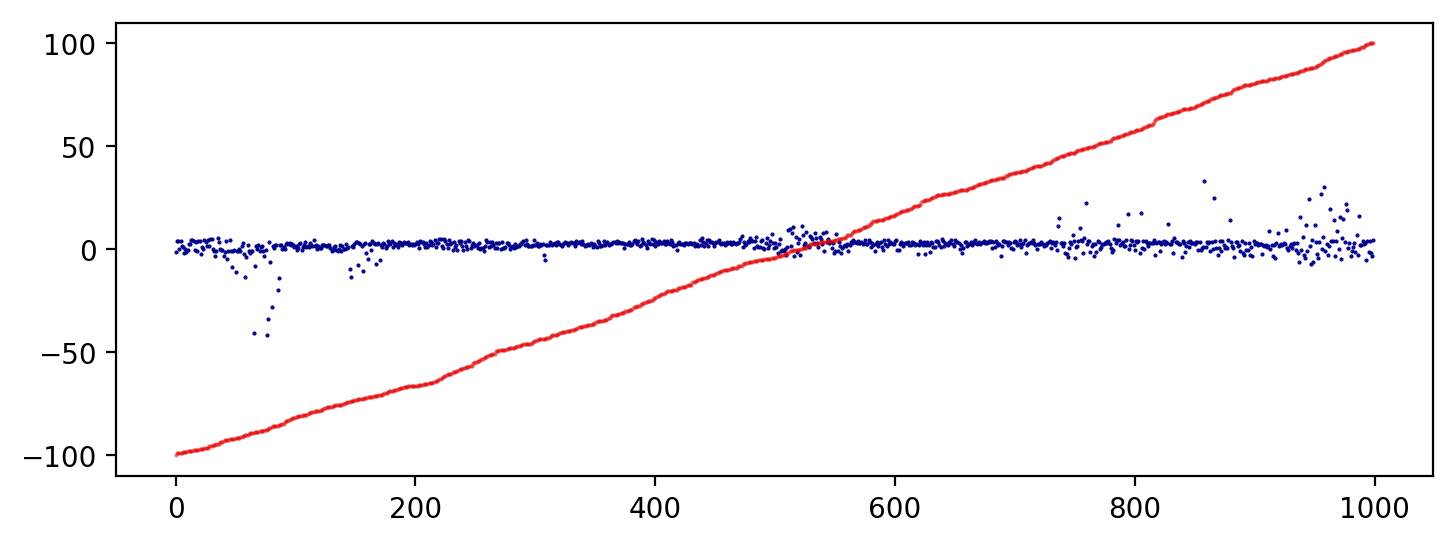

 epoch:  109 testing_cost: 0.0753810927

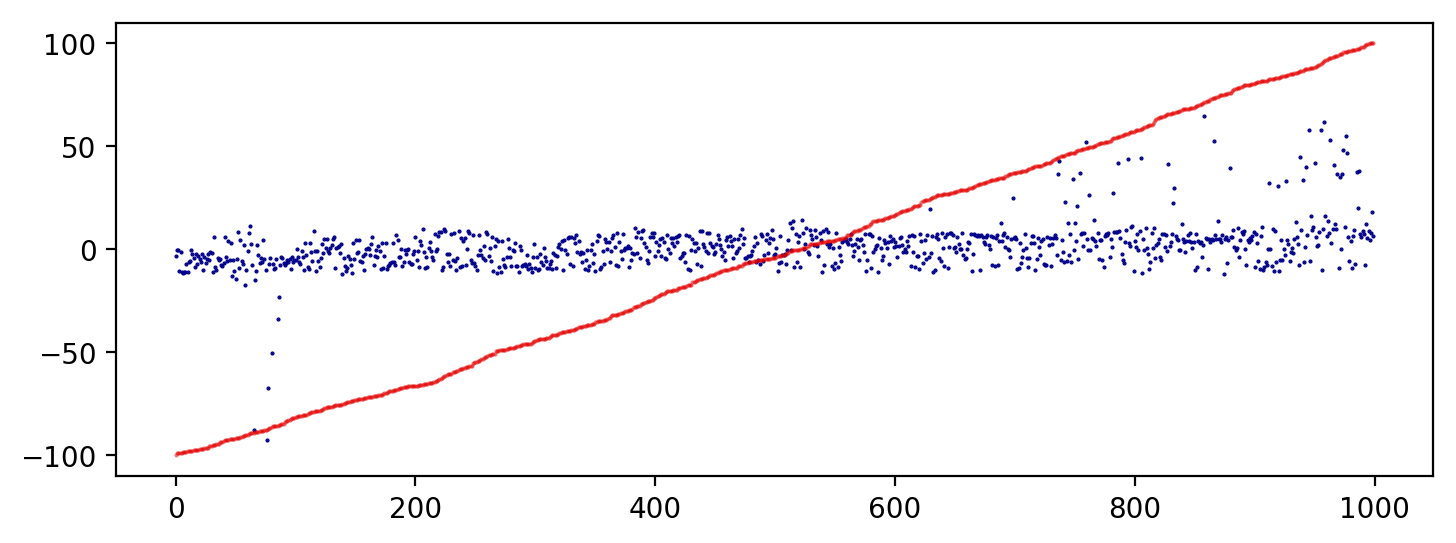

 epoch:  114 testing_cost: 0.0660509840

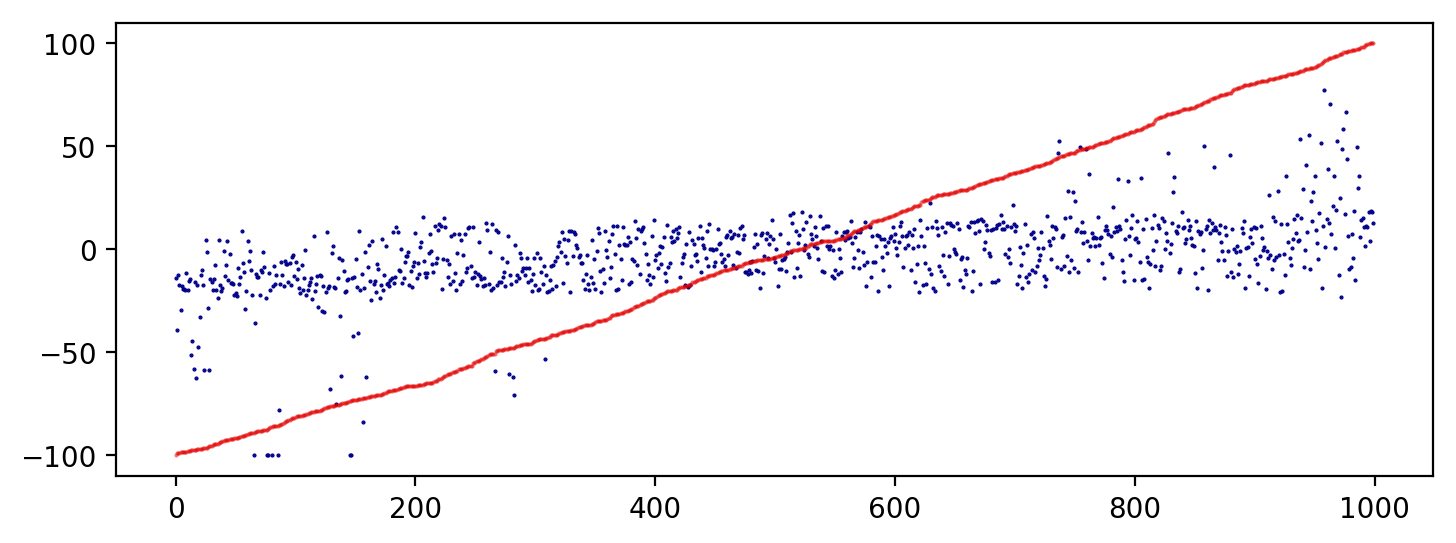

 epoch:  119 testing_cost: 0.0573367625

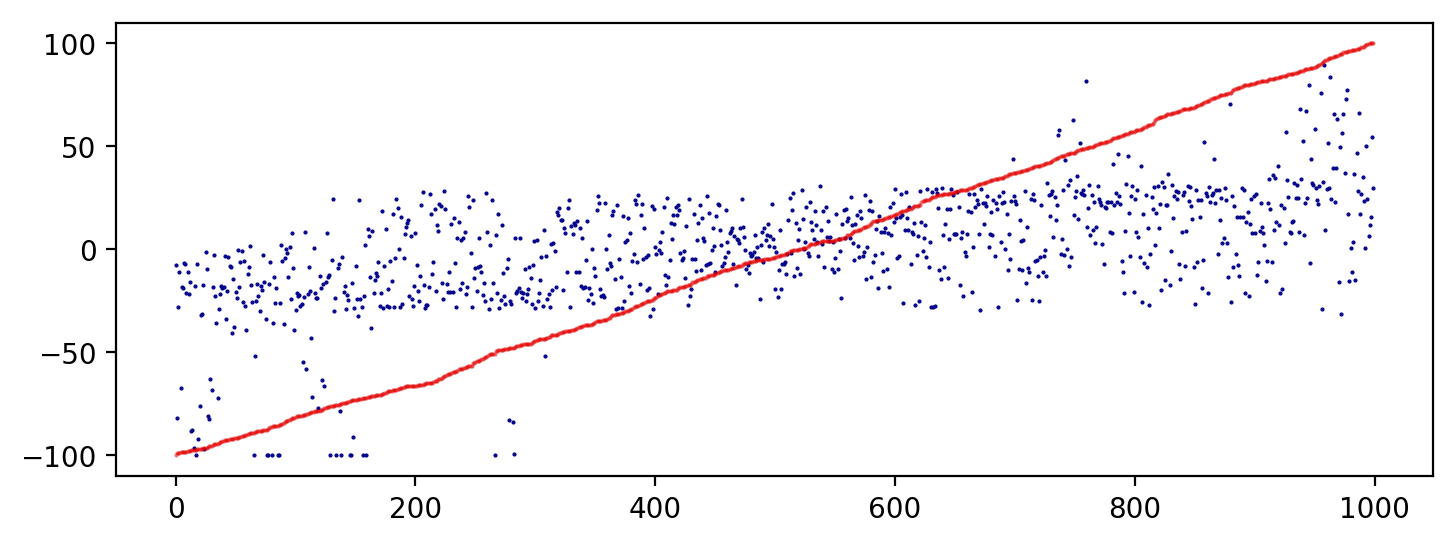

 epoch:  124 testing_cost: 0.0472268537

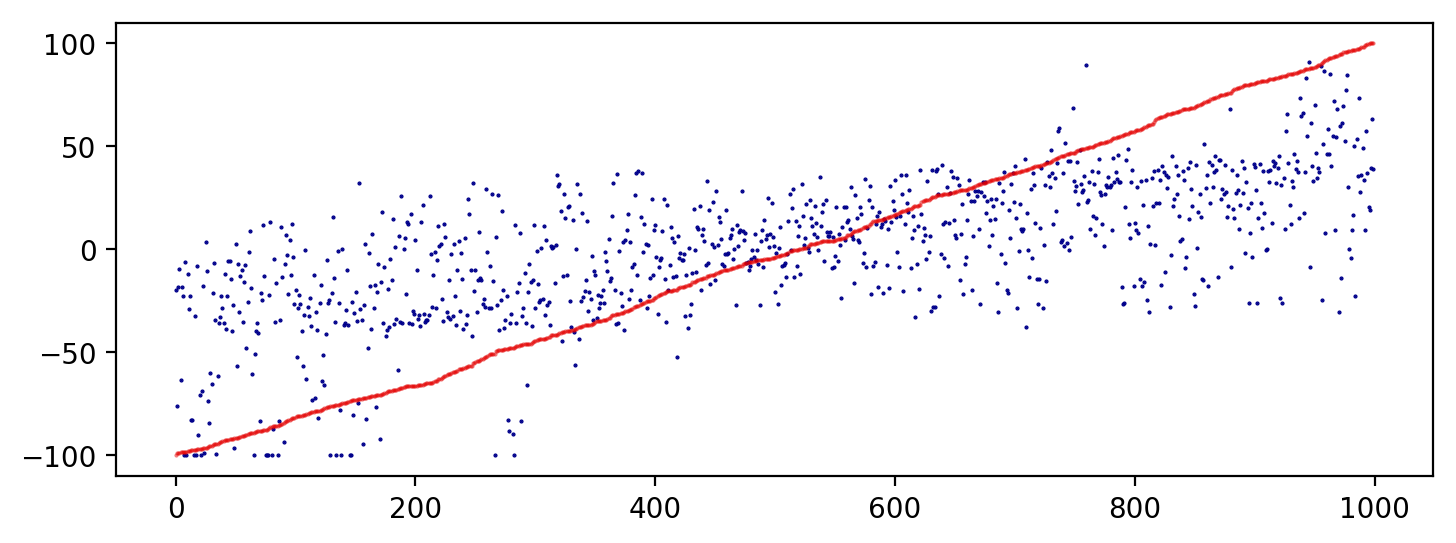

 epoch:  129 testing_cost: 0.0393767618

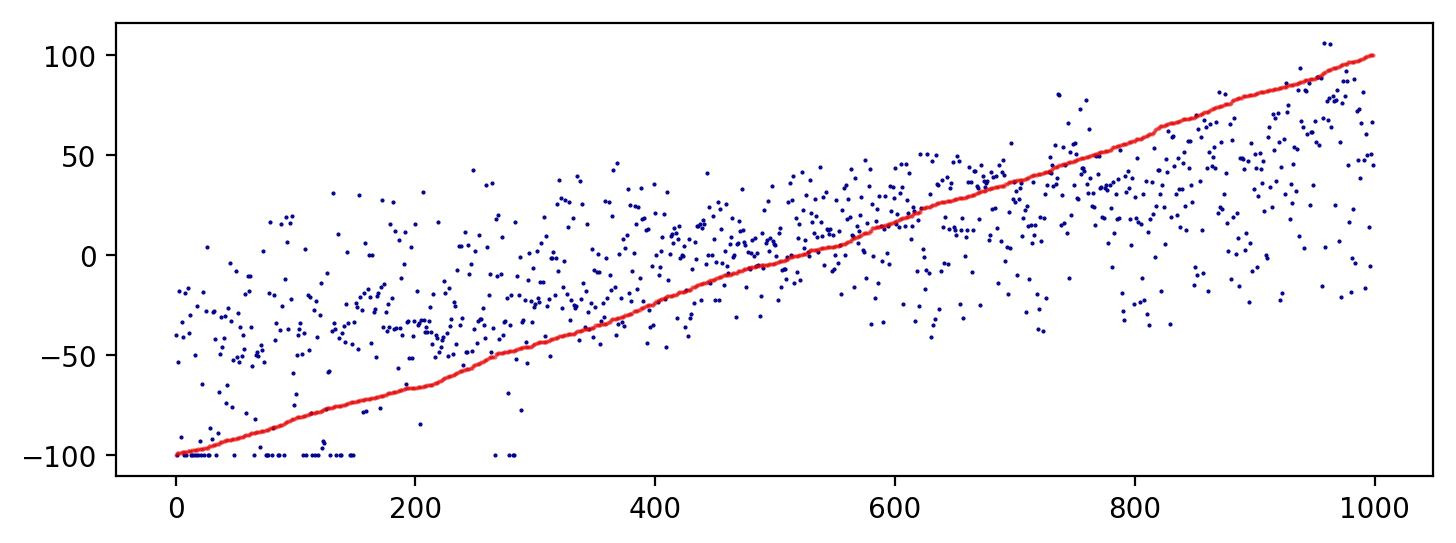

 epoch:  134 testing_cost: 0.0337832309

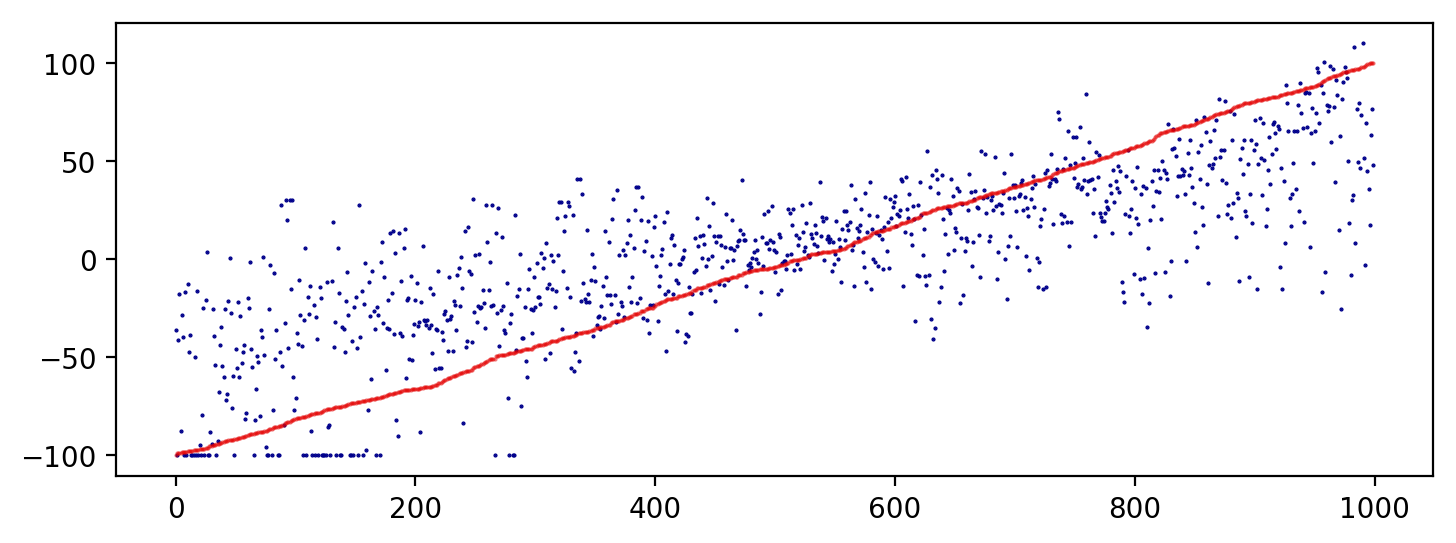

 epoch:  139 testing_cost: 0.0271816757

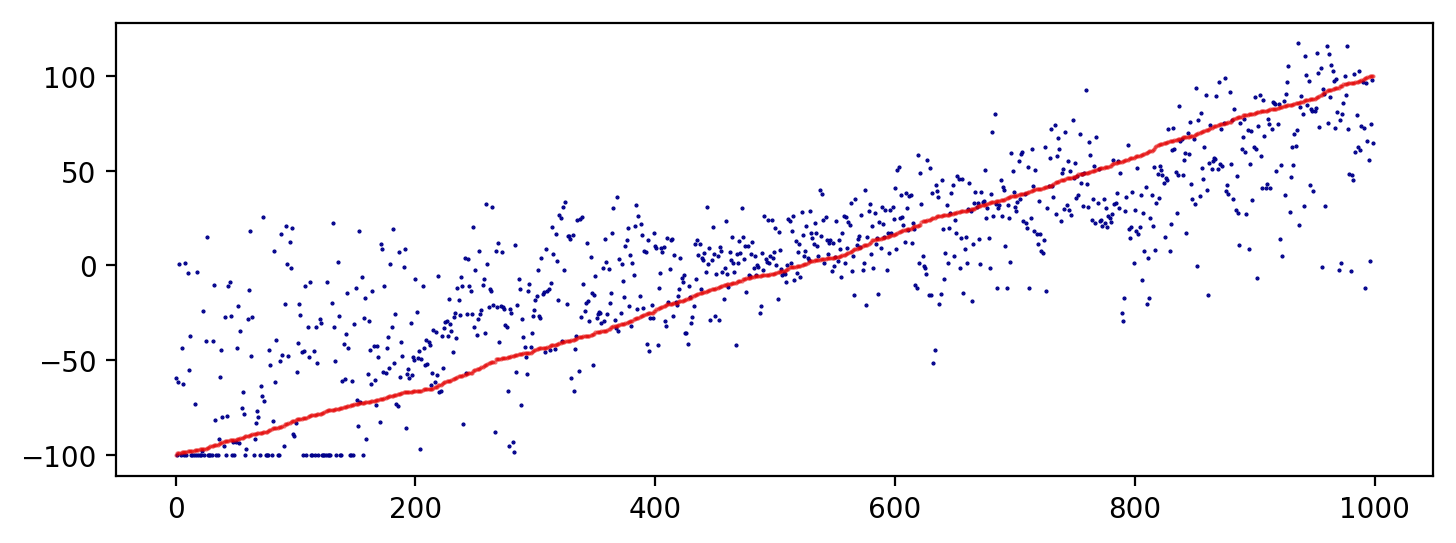

 epoch:  144 testing_cost: 0.0226521473

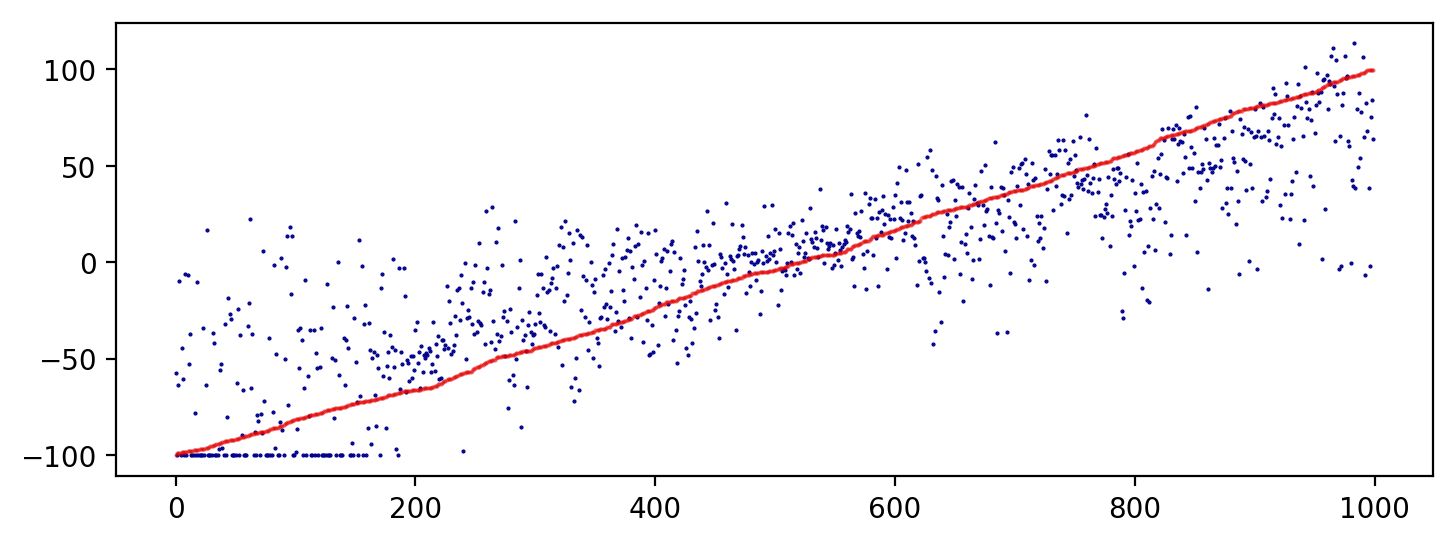

 epoch:  149 testing_cost: 0.0231190808

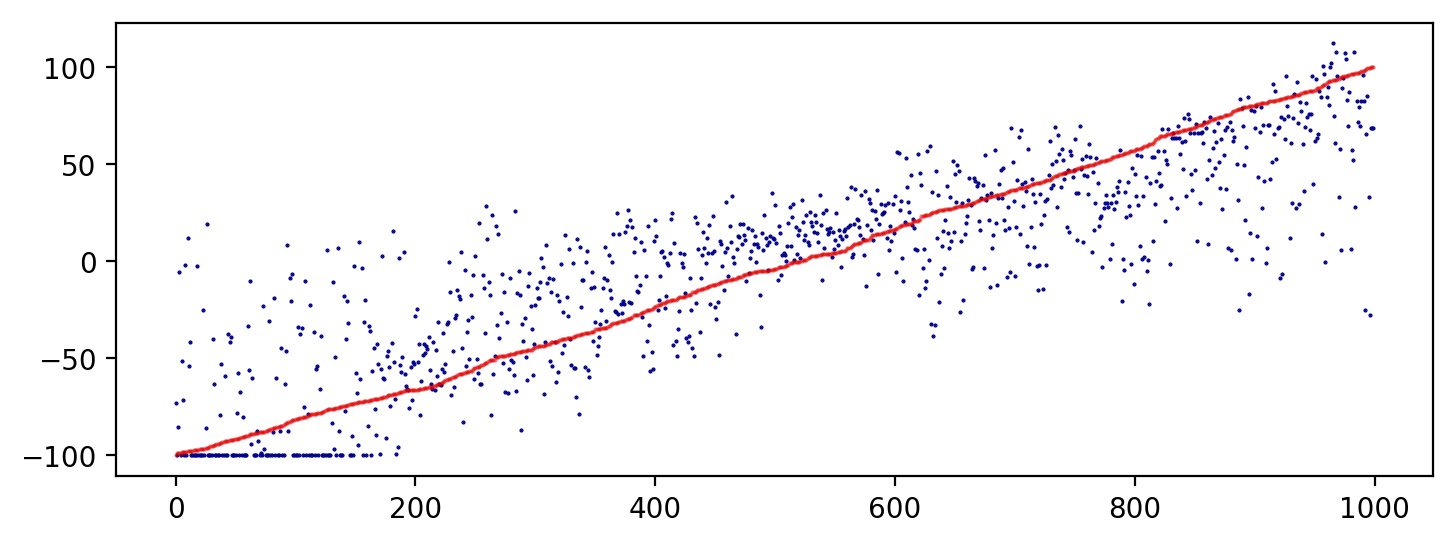

 epoch:  154 testing_cost: 0.0164112113

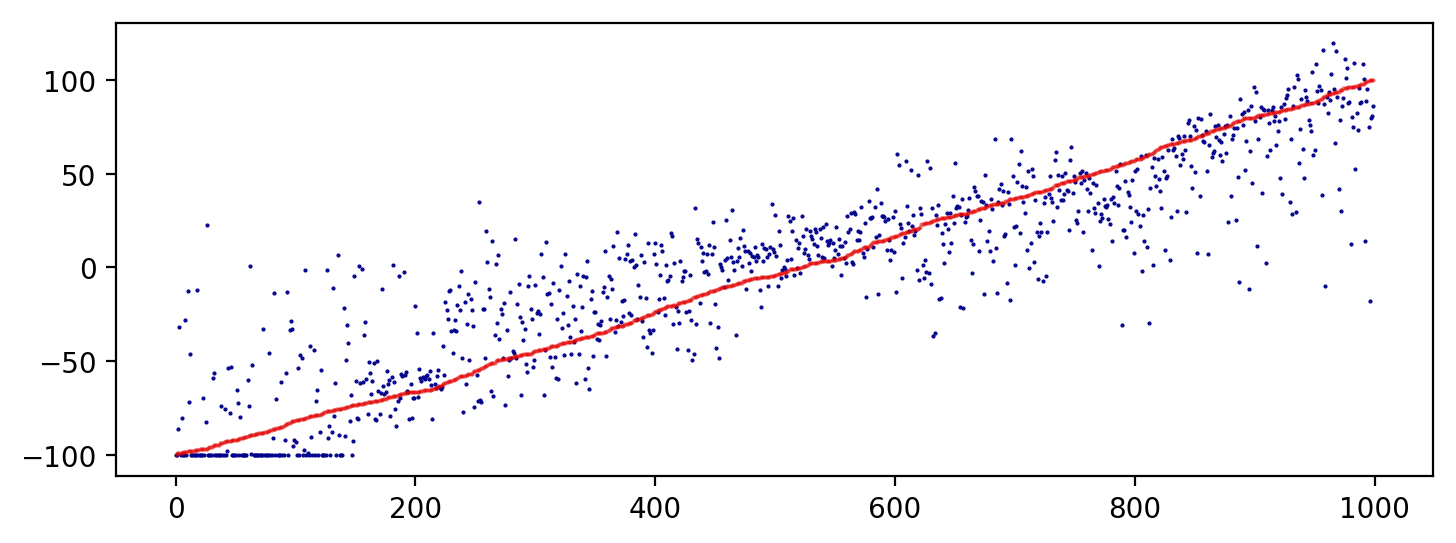

 epoch:  159 testing_cost: 0.0147489710

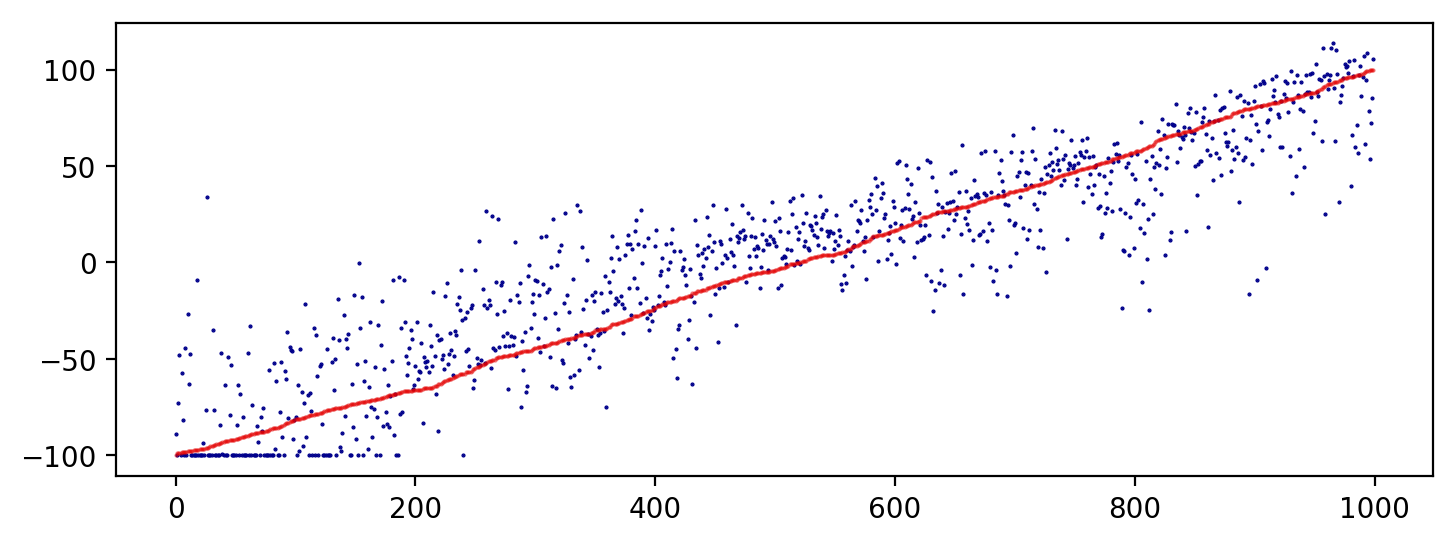

 epoch:  164 testing_cost: 0.0113648158

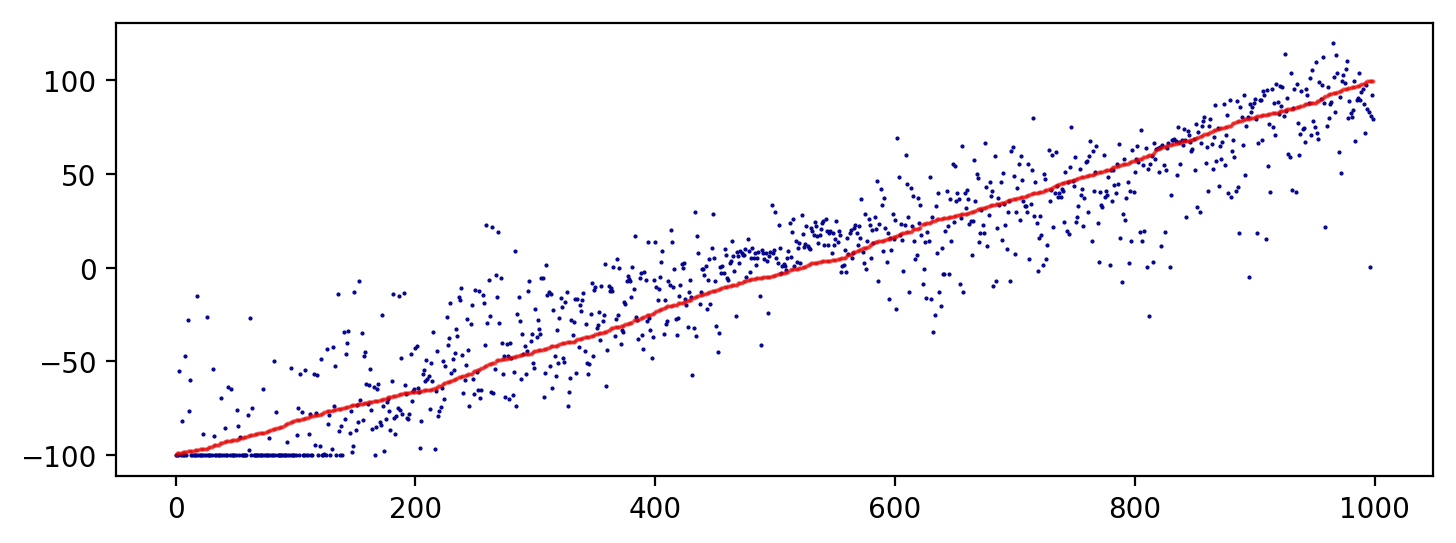

 epoch:  169 testing_cost: 0.0066650338

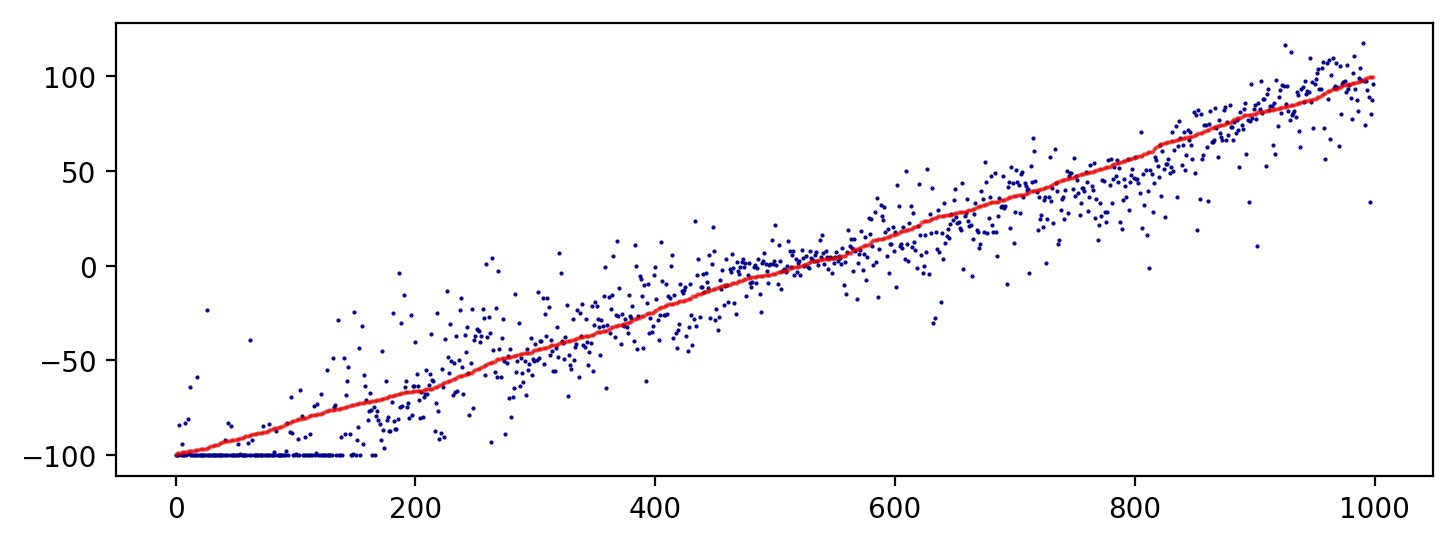

 epoch:  174 testing_cost: 0.0052379007

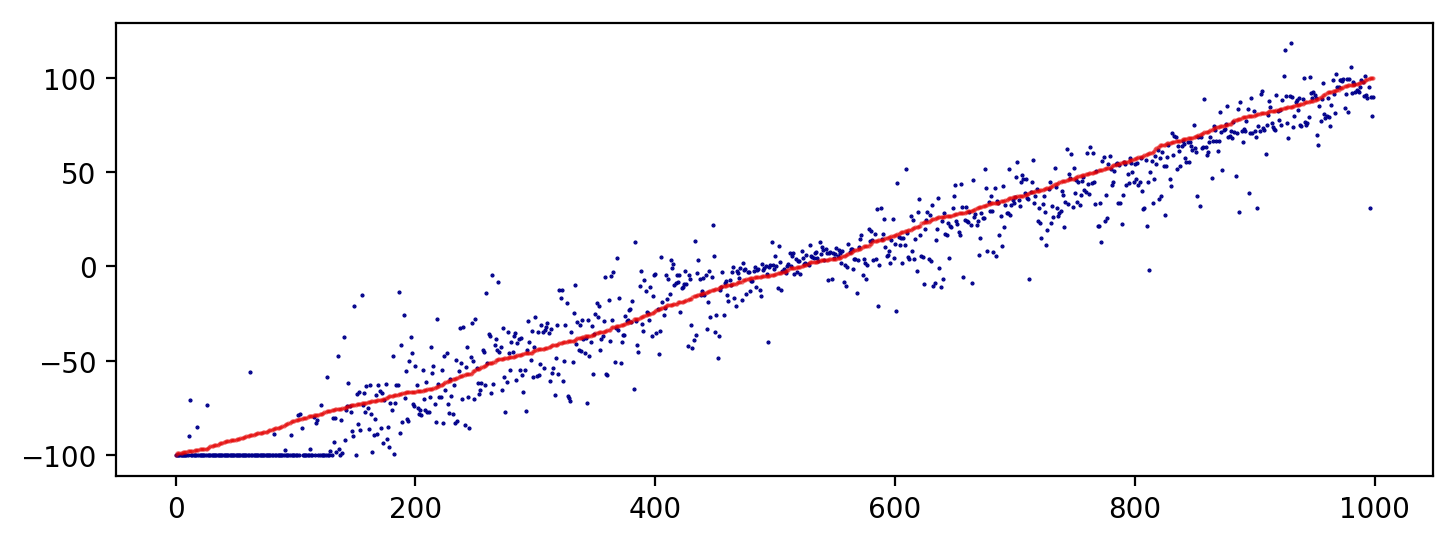

 epoch:  179 testing_cost: 0.0051548164

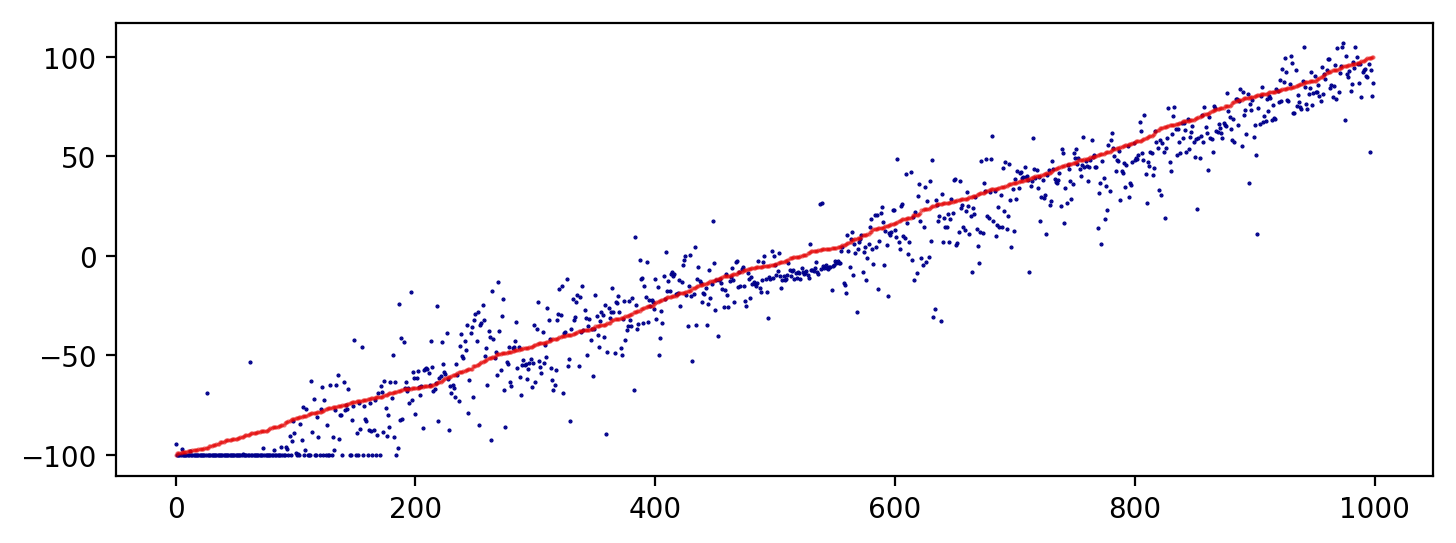

 epoch:  184 testing_cost: 0.0037539096

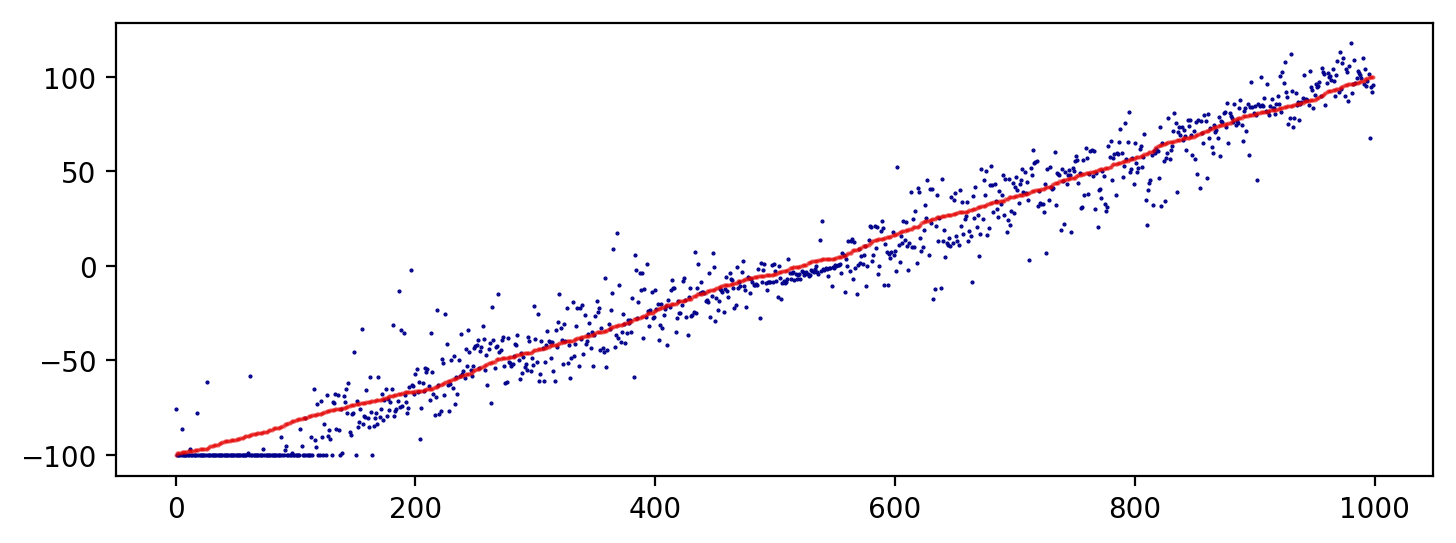

 epoch:  189 testing_cost: 0.0034657903

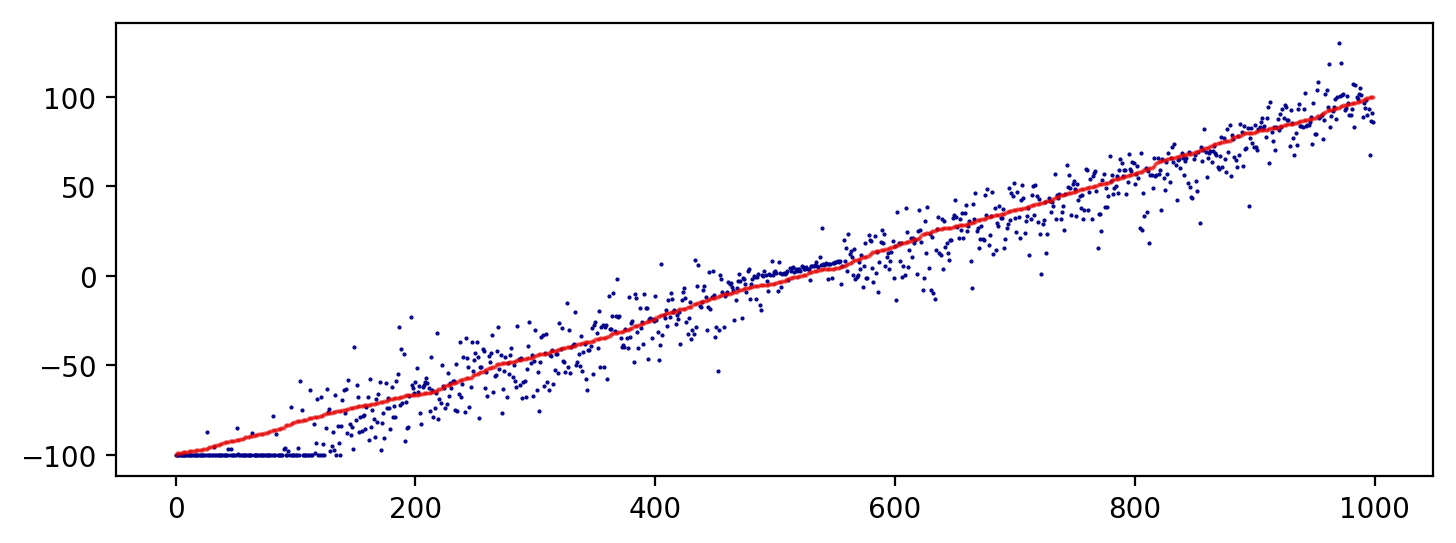

 epoch:  194 testing_cost: 0.0031299130

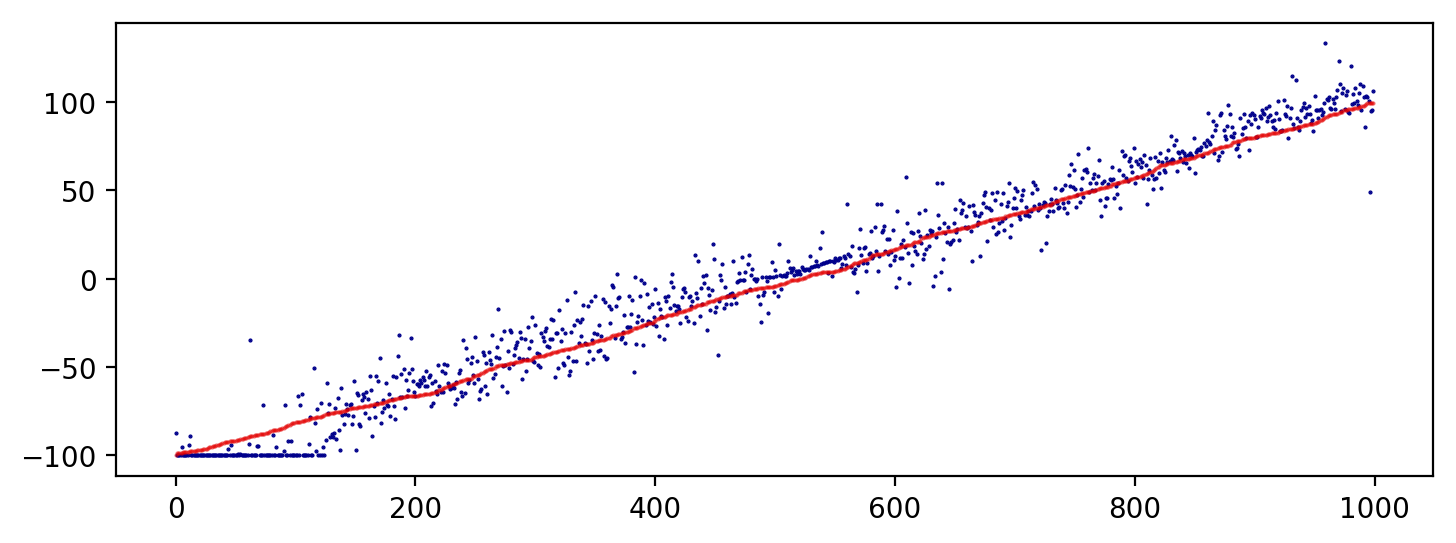

 epoch:  199 testing_cost: 0.0024652758

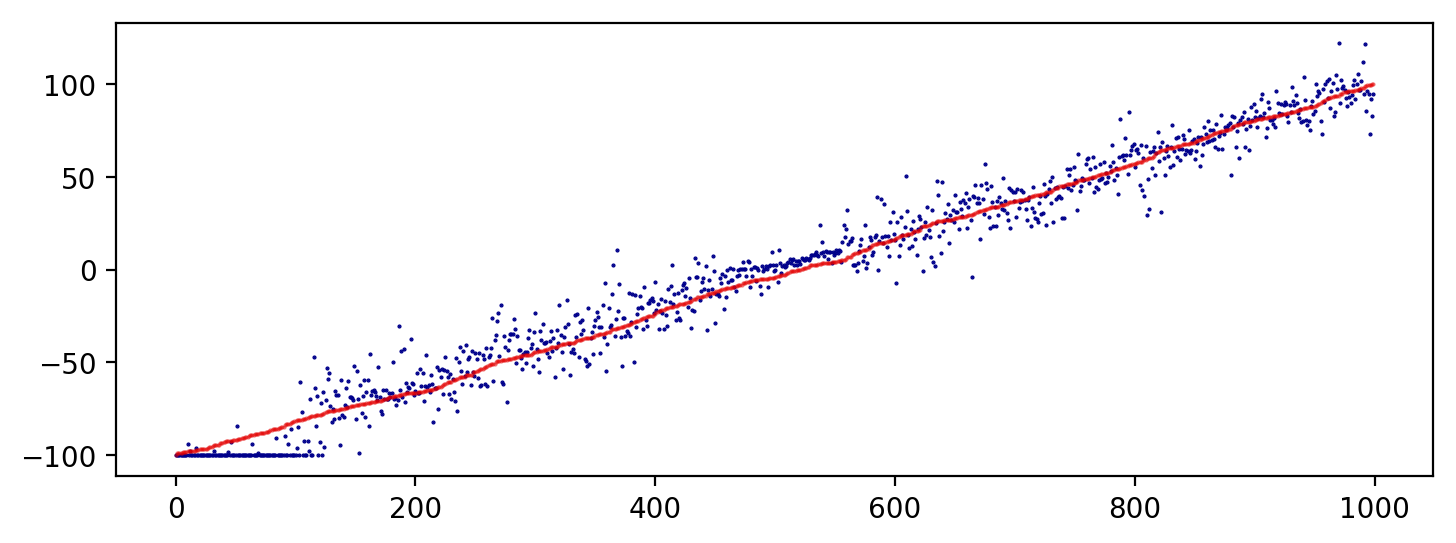

In [19]:
with tf.Session() as session:

    session.run(tf.global_variables_initializer())

    training_writer = tf.summary.FileWriter(log_direc + '/training', session.graph)
    testing_writer = tf.summary.FileWriter(log_direc + '/testing', session.graph)
    model_save_location = log_direc + '/trained_model.ckpt'


    for epoch in range(FLAGS.num_epochs):
        
        split_permutation = np.random.permutation(X_train.shape[0])
        X_train_batches = np.vsplit(X_train[split_permutation], 1000)
        y_train_batches = np.vsplit(y_train[split_permutation], 1000)
        
        for i in range(1000):
            X_train_batch = X_train_batches[i]
            y_train_batch = y_train_batches[i]
            sys.stdout.write('\r epoch: {:4.0f} batch: {:2.10f}'.format(epoch, i))
            session.run(optimizer,
                        feed_dict = {X: X_train_batch, y: y_train_batch, keep_prob : 0.50})

        
        training_feed = {X: X_train, y: y_train, keep_prob : 1.00}
        training_cost, training_summary = session.run([cost, summary], feed_dict = training_feed)

        
        testing_feed =  {X: X_test, y: y_test, keep_prob : 1.00}
        testing_cost, testing_summary = session.run([cost, summary],feed_dict = testing_feed)
        
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, testing_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()
        
        if (epoch + 1) % 5 == 0:
            
            saver.save(session, model_save_location, epoch)
            prediction_scaled = session.run(prediction, feed_dict = {X: X_test, keep_prob : 1.00})
            
            prediction_unscaled = output_scaler.inverse_transform(prediction_scaled)
            actual_unscaled = output_scaler.inverse_transform(y_test)
            
            sorting_idx = np.argsort(actual_unscaled.T[0])
            fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)
            
            ax.plot(prediction_unscaled.T[0][sorting_idx], linestyle = 'none', marker = '.', markersize = 1, color = 'darkblue')
            ax.plot(actual_unscaled.T[0][sorting_idx],     linestyle = 'none', marker = '.', markersize = 1, color = '#E50000', alpha = 0.50, )
            plt.show()
            
    saver.save(session, model_save_location, epoch)